In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from utils import PkdbModel, caffeine_idx, pktype_data, filter_out, convert_unit, unstring
plt.style.use('seaborn-whitegrid')
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def to_numeric(df_data):
    df_data[("weight","value")] = pd.to_numeric(df_data[("weight","value")])
    df_data[("weight","mean")] = pd.to_numeric(df_data[("weight","mean")])
    df_data["value_intervention"] = pd.to_numeric(df_data["value_intervention"])
    df_data["median"] = pd.to_numeric(df_data["median"])
    df_data["mean"] = pd.to_numeric(df_data["mean"])
    df_data["value"] = pd.to_numeric(df_data["value"])
    df_data["se"] = pd.to_numeric(df_data["se"])
    df_data["sd"] = pd.to_numeric(df_data["sd"])
    df_data["cv"] = pd.to_numeric(df_data["cv"])
    return df_data
     
def infer_from_interventions(data, unit_abs = "gram"):
    unit_rel= unit_abs + " / kilogram"
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=[("weight","value"),"value"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","value")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=[("weight","value"),"value"])
    
    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","mean")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'], 
                             subset=[("weight","mean"),"mean"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","mean")],
                             unit_field="unit_intervention", 
                             data_fields=['value_intervention'],
                             subset=[("weight","mean"),"mean"])
    
    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    return data

def infer_from_outputs(data, unit_abs="liter / hour"):
    unit_rel= unit_abs + " / kilogram"
    data_rel = convert_unit(data,
                                 unit_in=unit_abs,
                                 unit_out=unit_rel, 
                                 factor=1.0/data[("weight","value")],
                                 unit_field="unit", 
                                 data_fields=['value'], 
                                 subset=[("weight","value"),"value"])

    data_abs_i = convert_unit(data,
                                 unit_in=unit_rel,
                                 unit_out=unit_abs, 
                                 factor=data[("weight","value")],
                                 unit_field="unit", 
                                 data_fields=['value'],
                                 subset=[("weight","value"),"value"])
    

    data = pd.concat([data,data_rel,data_abs_i], ignore_index=True)
    
    data_rel = convert_unit(data,
                             unit_in=unit_abs,
                             unit_out=unit_rel, 
                             factor=1.0/data[("weight","mean")],
                             unit_field="unit", 
                             data_fields=['mean','median','sd', 'se'],
                             subset=[("weight","mean"),"mean"])

    data_abs = convert_unit(data,
                             unit_in=unit_rel,
                             unit_out=unit_abs, 
                             factor=data[("weight","mean")],
                             unit_field="unit", 
                             data_fields=['mean','median','sd', 'se'],
                             subset=[("weight","mean"),"mean"])


    data = pd.concat([data,data_rel,data_abs], ignore_index=True)
    
    return data

In [4]:
all_complete = PkdbModel("all_complete", destination="2-merged")
all_complete.read()
all_complete.data.loc[(all_complete.data[("sex","choice")] == "M"),("oral contraceptives","choice")] = "N"
complete_caffeine = all_complete.data[caffeine_idx(all_complete.data)]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (21,24,25,37,77,98,99,101,107,111,116,118,122,128,129,130,145,152,153,157,162,163,164,173,180,181,182,185,186,192,196,200,204,208,220,224,228,229,231,232,233,234,235,239,252) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
caffeine_clearance = pktype_data(complete_caffeine,"clearance")
caffeine_clearance = filter_out(caffeine_clearance,"unit",["milliliter / meter ** 2 / minute"])

In [6]:
caffeine_clearance.groupby(["unit"]).apply(len)

unit
liter / hour               404
liter / hour / kilogram    395
dtype: int64

In [7]:
caffeine_clearance = to_numeric(caffeine_clearance)
caffeine_clearance = infer_from_interventions(caffeine_clearance,"gram")
caffeine_clearance = infer_from_outputs(caffeine_clearance,"liter / hour")


In [8]:
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="liter / hour",unit_out="ml/min", factor=1000.0/60,data_fields=['mean','median','sd', 'se','value'])
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="gram",unit_out="mg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")

caffeine_clearance = convert_unit(caffeine_clearance,unit_in="liter / hour / kilogram",unit_out="ml/min/kg", factor=1000.0/60,data_fields=['mean','median','sd', 'se','value'])
caffeine_clearance = convert_unit(caffeine_clearance,unit_in="gram / kilogram",unit_out="mg/kg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")


In [9]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.data = caffeine_clearance
caffeine_clr.save()

In [10]:
caffeine_clearance.groupby(["unit", "unit_intervention"]).apply(len)

unit       unit_intervention
ml/min     mg                   626
           mg/kg                457
ml/min/kg  mg                   609
           mg/kg                478
dtype: int64

## Timecourses

In [11]:
caffeine_timecourse = pktype_data(complete_caffeine,"concentration")
caffeine_timecourse = filter_out(caffeine_timecourse,"output_type",["outputs"])


In [12]:
caffeine_timecourse.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  raw_pk  tissue  \
unit         unit_intervention                                            
gram / liter gram                 103          103  103     103     103   
             gram / kilogram       15           15   15      15      15   
mole / liter gram                   5            5    5       5       5   
             gram / kilogram       12           12   12      12      12   

                                interventions  substance_name  pktype  \
unit         unit_intervention                                          
gram / liter gram                         103             103     103   
             gram / kilogram               15              15      15   
mole / liter gram                           5               5       5   
             gram / kilogram               12              12      12   

                                calculated  individual_pk  ...  \
unit         unit_intervention                             ...   
gram / liter gram                        0             86  ...   
             gram / kilogram             0              5  ...   
mole / liter gram                        0              0  ...   
             gram / kilogram             0              0  ...   

                                (lean body mass, unit)  \
unit         unit_intervention                           
gram / liter gram                                    0   
             gram / kilogram                         0   
mole / liter gram                                    0   
             gram / kilogram                         0   

                                (metabolic ratio, count)  \
unit         unit_intervention                             
gram / liter gram                                      0   
             gram / kilogram                           0   
mole / liter gram                                      0   
             gram / kilogram                           0   

                                (metabolic ratio, max)  \
unit         unit_intervention                           
gram / liter gram                                    0   
             gram / kilogram                         0   
mole / liter gram                                    0   
             gram / kilogram                         0   

                                (metabolic ratio, mean)  \
unit         unit_intervention                            
gram / liter gram                                     0   
             gram / kilogram                          0   
mole / liter gram                                     0   
             gram / kilogram                          0   

                                (metabolic ratio, min)  \
unit         unit_intervention                           
gram / liter gram                                    0   
             gram / kilogram                         0   
mole / liter gram                                    0   
             gram / kilogram                         0   

                                (metabolic ratio, unit)  (fat weight, count)  \
unit         unit_intervention                                                 
gram / liter gram                                     0                    0   
             gram / kilogram                          0                    0   
mole / liter gram                                     0                    0   
             gram / kilogram                          0                   12   

                                (fat weight, mean)  (fat weight, se)  \
unit         unit_intervention                                         
gram / liter gram                                0                 0   
             gram / kilogram                     0                 0   
mole / liter gram                                0                 0   
             gram / kilogram                    12                12   

                                (fat weight, unit)  
unit         un

In [13]:
caffeine_timecourse = filter_out(caffeine_timecourse,"unit",["mole / liter"])
caffeine_timecourse.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  raw_pk  tissue  \
unit         unit_intervention                                            
gram / liter gram                 103          103  103     103     103   
             gram / kilogram       15           15   15      15      15   

                                interventions  substance_name  pktype  \
unit         unit_intervention                                          
gram / liter gram                         103             103     103   
             gram / kilogram               15              15      15   

                                calculated  individual_pk  ...  \
unit         unit_intervention                             ...   
gram / liter gram                        0             86  ...   
             gram / kilogram             0              5  ...   

                                (lean body mass, unit)  \
unit         unit_intervention                           
gram / liter gram                                    0   
             gram / kilogram                         0   

                                (metabolic ratio, count)  \
unit         unit_intervention                             
gram / liter gram                                      0   
             gram / kilogram                           0   

                                (metabolic ratio, max)  \
unit         unit_intervention                           
gram / liter gram                                    0   
             gram / kilogram                         0   

                                (metabolic ratio, mean)  \
unit         unit_intervention                            
gram / liter gram                                     0   
             gram / kilogram                          0   

                                (metabolic ratio, min)  \
unit         unit_intervention                           
gram / liter gram                                    0   
             gram / kilogram                         0   

                                (metabolic ratio, unit)  (fat weight, count)  \
unit         unit_intervention                                                 
gram / liter gram                                     0                    0   
             gram / kilogram                          0                    0   

                                (fat weight, mean)  (fat weight, se)  \
unit         unit_intervention                                         
gram / liter gram                                0                 0   
             gram / kilogram                     0                 0   

                                (fat weight, unit)  
unit         unit_intervention                      
gram / liter gram                                0  
             gram / kilogram                     0  

[2 rows x 250 columns]

In [14]:
caffeine_tc = PkdbModel("caffeine_timecourse",destination="3-inferred")
caffeine_tc.data = caffeine_timecourse
caffeine_tc.to_array()
caffeine_timecourse = caffeine_tc.data

In [15]:
caffeine_timecourse = infer_from_interventions(caffeine_timecourse,"gram")
caffeine_timecourse = infer_from_outputs(caffeine_timecourse,"gram / liter")

In [16]:
caffeine_timecourse.groupby(["unit","unit_intervention","time_unit"]).count()

study  output_type   pk  \
unit                    unit_intervention time_unit                            
gram / liter            gram              hr           111          111  111   
                        gram / kilogram   hr           108          108  108   
gram / liter / kilogram gram              hr           101          101  101   
                        gram / kilogram   hr           101          101  101   

                                                     raw_pk  tissue  \
unit                    unit_intervention time_unit                   
gram / liter            gram              hr            111     111   
                        gram / kilogram   hr            108     108   
gram / liter / kilogram gram              hr            101     101   
                        gram / kilogram   hr            101     101   

                                                     interventions  \
unit                    unit_intervention time_unit                  
gram / liter            gram              hr                   111   
                        gram / kilogram   hr                   108   
gram / liter / kilogram gram              hr                   101   
                        gram / kilogram   hr                   101   

                                                     substance_name  pktype  \
unit                    unit_intervention time_unit                           
gram / liter            gram              hr                    111     111   
                        gram / kilogram   hr                    108     108   
gram / liter / kilogram gram              hr                    101     101   
                        gram / kilogram   hr                    101     101   

                                                     calculated  \
unit                    unit_intervention time_unit               
gram / liter            gram              hr                  0   
                        gram / kilogram   hr                  0   
gram / liter / kilogram gram              hr                  0   
                        gram / kilogram   hr                  0   

                                                     individual_pk  ...  \
unit                    unit_intervention time_unit                 ...   
gram / liter            gram              hr                    86  ...   
                        gram / kilogram   hr                    89  ...   
gram / liter / kilogram gram              hr                    84  ...   
                        gram / kilogram   hr                    84  ...   

                                                     (lean body mass, unit)  \
unit                    unit_intervention time_unit                           
gram / liter            gram              hr                              0   
                        gram / kilogram   hr                              0   
gram / liter / kilogram gram              hr                              0   
                        gram / kilogram   hr                              0   

                                                     (metabolic ratio, count)  \
unit                    unit_intervention time_unit                             
gram / liter            gram              hr                                0   
                        gram / kilogram   hr                                0   
gram / liter / kilogram gram              hr                                0   
                        gram / kilogram   hr                                0   

                                                     (metabolic ratio, max)  \
unit                    unit_intervention time_unit                           
gram / liter            gram              hr                              0   
                        gram / kilogram   hr                              0   
gram / liter / kilogram gram              hr                              0   
                        gram / kilogra

In [17]:
caffeine_tc = PkdbModel("caffeine_timecourse",destination="3-inferred")
caffeine_tc.data = caffeine_timecourse
caffeine_tc.save()

In [18]:
caffeine_thalf = pktype_data(complete_caffeine,"thalf")
caffeine_thalf = to_numeric(caffeine_thalf)
caffeine_thalf.groupby(["unit","unit_intervention"]).count()


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

study  output_type   pk  raw_pk  tissue  \
unit unit_intervention                                            
hour gram                 512          512  512     512     512   
     gram / kilogram       85           85   85      85      85   

                        interventions  substance_name  pktype  calculated  \
unit unit_intervention                                                      
hour gram                         512             512     512         512   
     gram / kilogram               85              85      85          85   

                        individual_pk  ...  (lean body mass, unit)  \
unit unit_intervention                 ...                           
hour gram                         429  ...                       0   
     gram / kilogram               41  ...                       0   

                        (metabolic ratio, count)  (metabolic ratio, max)  \
unit unit_intervention                                                     
hour gram                                      0                       0   
     gram / kilogram                           0                       0   

                        (metabolic ratio, mean)  (metabolic ratio, min)  \
unit unit_intervention                                                    
hour gram                                     0                       0   
     gram / kilogram                          0                       0   

                        (metabolic ratio, unit)  (fat weight, count)  \
unit unit_intervention                                                 
hour gram                                     0                    0   
     gram / kilogram                          0                   18   

                        (fat weight, mean)  (fat weight, se)  \
unit unit_intervention                                         
hour gram                                0                 0   
     gram / kilogram                    18                18   

                        (fat weight, unit)  
unit unit_intervention                      
hour gram                                0  
     gram / kilogram                    18  

[2 rows x 250 columns]

In [19]:
caffeine_thalf = infer_from_interventions(caffeine_thalf,"gram")
caffeine_thalf = infer_from_outputs(caffeine_thalf,"hour")

In [20]:
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="hour",unit_out="hr", factor=1,data_fields=['mean','median','sd', 'se','value'])
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="gram",unit_out="mg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")

caffeine_thalf = convert_unit(caffeine_thalf,unit_in="hour / kilogram",unit_out="hr/kg", factor=1,data_fields=['mean','median','sd', 'se','value'])
caffeine_thalf = convert_unit(caffeine_thalf,unit_in="gram / kilogram",unit_out="mg/kg", factor=1000.0,data_fields=['value_intervention'],unit_field="unit_intervention")


In [21]:
caffeine_thalf.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  raw_pk  tissue  \
unit  unit_intervention                                            
hr    mg                   576          576  576     576     576   
      mg/kg                467          467  467     467     467   
hr/kg mg                   446          446  446     446     446   
      mg/kg                446          446  446     446     446   

                         interventions  substance_name  pktype  calculated  \
unit  unit_intervention                                                      
hr    mg                           576             576     576         576   
      mg/kg                        467             467     467         467   
hr/kg mg                           446             446     446         446   
      mg/kg                        446             446     446         446   

                         individual_pk  ...  (lean body mass, unit)  \
unit  unit_intervention                 ...                           
hr    mg                           453  ...                       0   
      mg/kg                        375  ...                       0   
hr/kg mg                           358  ...                       0   
      mg/kg                        358  ...                       0   

                         (metabolic ratio, count)  (metabolic ratio, max)  \
unit  unit_intervention                                                     
hr    mg                                        0                       0   
      mg/kg                                     0                       0   
hr/kg mg                                        0                       0   
      mg/kg                                     0                       0   

                         (metabolic ratio, mean)  (metabolic ratio, min)  \
unit  unit_intervention                                                    
hr    mg                                       0                       0   
      mg/kg                                    0                       0   
hr/kg mg                                       0                       0   
      mg/kg                                    0                       0   

                         (metabolic ratio, unit)  (fat weight, count)  \
unit  unit_intervention                                                 
hr    mg                                       0                   18   
      mg/kg                                    0                   18   
hr/kg mg                                       0                   18   
      mg/kg                                    0                   18   

                         (fat weight, mean)  (fat weight, se)  \
unit  unit_intervention                                         
hr    mg                                 18                18   
      mg/kg                              18                18   
hr/kg mg                                 18                18   
      mg/kg                              18                18   

                         (fat weight, unit)  
unit  unit_intervention                      
hr    mg                                 18  
      mg/kg                              18  
hr/kg mg                                 18  
      mg/kg                              18  

[4 rows x 250 columns]

In [22]:
caffeine_thf = PkdbModel("caffeine_thalf",destination="3-inferred")
caffeine_thf.data = caffeine_thalf
caffeine_thf.save()

In [23]:
caffeine_tmax = pktype_data(complete_caffeine,"tmax")
caffeine_tmax = to_numeric(caffeine_tmax)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [24]:
caffeine_tmax.groupby(["unit","unit_intervention"]).count()


study  output_type   pk  raw_pk  tissue  \
unit unit_intervention                                            
hour gram                 114          114  114     114     114   
     gram / kilogram       23           23   23      23      23   

                        interventions  substance_name  pktype  calculated  \
unit unit_intervention                                                      
hour gram                         114             114     114         114   
     gram / kilogram               23              23      23          23   

                        individual_pk  ...  (lean body mass, unit)  \
unit unit_intervention                 ...                           
hour gram                          77  ...                       0   
     gram / kilogram               12  ...                       0   

                        (metabolic ratio, count)  (metabolic ratio, max)  \
unit unit_intervention                                                     
hour gram                                      0                       0   
     gram / kilogram                           0                       0   

                        (metabolic ratio, mean)  (metabolic ratio, min)  \
unit unit_intervention                                                    
hour gram                                     0                       0   
     gram / kilogram                          0                       0   

                        (metabolic ratio, unit)  (fat weight, count)  \
unit unit_intervention                                                 
hour gram                                     0                    0   
     gram / kilogram                          0                    8   

                        (fat weight, mean)  (fat weight, se)  \
unit unit_intervention                                         
hour gram                                0                 0   
     gram / kilogram                     8                 8   

                        (fat weight, unit)  
unit unit_intervention                      
hour gram                                0  
     gram / kilogram                     8  

[2 rows x 250 columns]

In [25]:
caffeine_tmax = infer_from_interventions(caffeine_tmax)
caffeine_tmax = infer_from_outputs(caffeine_tmax, "hour")

In [26]:
caffeine_tmax.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  raw_pk  tissue  \
unit            unit_intervention                                            
hour            gram                 123          123  123     123     123   
                gram / kilogram       66           66   66      66      66   
hour / kilogram gram                  52           52   52      52      52   
                gram / kilogram       52           52   52      52      52   

                                   interventions  substance_name  pktype  \
unit            unit_intervention                                          
hour            gram                         123             123     123   
                gram / kilogram               66              66      66   
hour / kilogram gram                          52              52      52   
                gram / kilogram               52              52      52   

                                   calculated  individual_pk  ...  \
unit            unit_intervention                             ...   
hour            gram                      123             77  ...   
                gram / kilogram            66             32  ...   
hour / kilogram gram                       52             20  ...   
                gram / kilogram            52             20  ...   

                                   (lean body mass, unit)  \
unit            unit_intervention                           
hour            gram                                    0   
                gram / kilogram                         0   
hour / kilogram gram                                    0   
                gram / kilogram                         0   

                                   (metabolic ratio, count)  \
unit            unit_intervention                             
hour            gram                                      0   
                gram / kilogram                           0   
hour / kilogram gram                                      0   
                gram / kilogram                           0   

                                   (metabolic ratio, max)  \
unit            unit_intervention                           
hour            gram                                    0   
                gram / kilogram                         0   
hour / kilogram gram                                    0   
                gram / kilogram                         0   

                                   (metabolic ratio, mean)  \
unit            unit_intervention                            
hour            gram                                     0   
                gram / kilogram                          0   
hour / kilogram gram                                     0   
                gram / kilogram                          0   

                                   (metabolic ratio, min)  \
unit            unit_intervention                           
hour            gram                                    0   
                gram / kilogram                         0   
hour / kilogram gram                                    0   
                gram / kilogram                         0   

                                   (metabolic ratio, unit)  \
unit            unit_intervention                            
hour            gram                                     0   
                gram / kilogram                          0   
hour / kilogram gram                                     0   
                gram / kilogram                          0   

                                   (fat weight, count)  (fat weight, mean)  \
unit            unit_intervention                                            
hour            gram                                 8                   8   
                gram / kilogram                      8                   8   
hour / kilogram gram                                 8                   8   
                gram / kilogram                      8                   8   


In [27]:
caffeine_tmx = PkdbModel("caffeine_tmax",destination="3-inferred")
caffeine_tmx.data = caffeine_tmax
caffeine_tmx.save()

In [28]:
caffeine_vd = pktype_data(complete_caffeine,"vd")
caffeine_vd = to_numeric(caffeine_vd)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [29]:
caffeine_vd.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  raw_pk  tissue  \
unit             unit_intervention                                            
liter            gram                 242          242  242     242     242   
                 gram / kilogram       11           11   11      11      11   
liter / kilogram gram                 160          160  160     160     160   
                 gram / kilogram       62           62   62      62      62   

                                    interventions  substance_name  pktype  \
unit             unit_intervention                                          
liter            gram                         242             242     242   
                 gram / kilogram               11              11      11   
liter / kilogram gram                         160             160     160   
                 gram / kilogram               62              62      62   

                                    calculated  individual_pk  ...  \
unit             unit_intervention                             ...   
liter            gram                      242            207  ...   
                 gram / kilogram            11              0  ...   
liter / kilogram gram                      160            120  ...   
                 gram / kilogram            62             26  ...   

                                    (lean body mass, unit)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (metabolic ratio, count)  \
unit             unit_intervention                             
liter            gram                                      0   
                 gram / kilogram                           0   
liter / kilogram gram                                      0   
                 gram / kilogram                           0   

                                    (metabolic ratio, max)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (metabolic ratio, mean)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (metabolic ratio, min)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (metabolic ratio, unit)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (fat weight, count)  (fat weight, mean)  \
unit             unit_intervention                                            
liter            gram                                 0                   0   
                 gram / kilogram                      0                   0   
liter / kilogram gram                                 0                   0   
                 gra

In [30]:
caffeine_vd["weight"] = caffeine_vd[("weight","mean")]
caffeine_vd[(caffeine_vd["group_pk"] == 601) & (caffeine_vd["value_intervention"] == 0.003)][["study","group_count","group_pk","mean","unit","unit_intervention","value_intervention","weight"]]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,study,group_count,group_pk,mean,unit,unit_intervention,value_intervention,weight


In [31]:
71*1.050000

74.55

In [32]:
49.33*1.05

51.7965

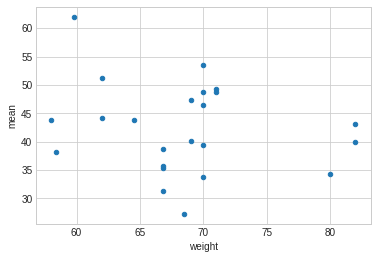

In [33]:
caffeine_vd[caffeine_vd["unit"]=="liter"][["weight","mean","value"]].plot(x="weight",y="mean",kind="scatter")

In [34]:
caffeine_vd =  infer_from_interventions(caffeine_vd, "gram")
caffeine_vd =  infer_from_outputs(caffeine_vd, "liter")

In [35]:
caffeine_vd[(caffeine_vd["group_pk"] == 601) & (caffeine_vd["value_intervention"] == 0.003)][["study","group_count","group_pk","mean","unit","unit_intervention","value_intervention"]]

,study,group_count,group_pk,mean,unit,unit_intervention,value_intervention


In [36]:
caffeine_vd.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  raw_pk  tissue  \
unit             unit_intervention                                            
liter            gram                 385          385  385     385     385   
                 gram / kilogram      341          341  341     341     341   
liter / kilogram gram                 408          408  408     408     408   
                 gram / kilogram      364          364  364     364     364   

                                    interventions  substance_name  pktype  \
unit             unit_intervention                                          
liter            gram                         385             385     385   
                 gram / kilogram              341             341     341   
liter / kilogram gram                         408             408     408   
                 gram / kilogram              364             364     364   

                                    calculated  individual_pk  ...  \
unit             unit_intervention                             ...   
liter            gram                      385            282  ...   
                 gram / kilogram           341            261  ...   
liter / kilogram gram                      408            315  ...   
                 gram / kilogram           364            278  ...   

                                    (metabolic ratio, count)  \
unit             unit_intervention                             
liter            gram                                      0   
                 gram / kilogram                           0   
liter / kilogram gram                                      0   
                 gram / kilogram                           0   

                                    (metabolic ratio, max)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (metabolic ratio, mean)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (metabolic ratio, min)  \
unit             unit_intervention                           
liter            gram                                    0   
                 gram / kilogram                         0   
liter / kilogram gram                                    0   
                 gram / kilogram                         0   

                                    (metabolic ratio, unit)  \
unit             unit_intervention                            
liter            gram                                     0   
                 gram / kilogram                          0   
liter / kilogram gram                                     0   
                 gram / kilogram                          0   

                                    (fat weight, count)  (fat weight, mean)  \
unit             unit_intervention                                            
liter            gram                                18                  18   
                 gram / kilogram                     18                  18   
liter / kilogram gram                                18                  18   
                 gram / kilogram                     18                  18   

                                    (fat weight, se)  (fat weight, unit)  \
unit             unit_intervention                                         
liter            gram                             18                  18   
                 gram / kilogram                  18                  18   
liter / k

In [37]:
caffeine_vd_model = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_vd_model.data = caffeine_vd
caffeine_vd_model.save()

In [38]:
caffeine_auc_inf = pktype_data(complete_caffeine,"auc_inf")
caffeine_auc_inf = to_numeric(caffeine_auc_inf)
caffeine_auc_inf.groupby(["unit","unit_intervention"]).count()

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

study  output_type   pk  raw_pk  \
unit                unit_intervention                                    
gram * hour / liter gram                 317          317  317     317   
                    gram / kilogram       35           35   35      35   

                                       tissue  interventions  substance_name  \
unit                unit_intervention                                          
gram * hour / liter gram                  317            317             317   
                    gram / kilogram        35             35              35   

                                       pktype  calculated  individual_pk  ...  \
unit                unit_intervention                                     ...   
gram * hour / liter gram                  317         317            280  ...   
                    gram / kilogram        35          35              5  ...   

                                       (lean body mass, unit)  \
unit                unit_intervention                           
gram * hour / liter gram                                    0   
                    gram / kilogram                         0   

                                       (metabolic ratio, count)  \
unit                unit_intervention                             
gram * hour / liter gram                                      0   
                    gram / kilogram                           0   

                                       (metabolic ratio, max)  \
unit                unit_intervention                           
gram * hour / liter gram                                    0   
                    gram / kilogram                         0   

                                       (metabolic ratio, mean)  \
unit                unit_intervention                            
gram * hour / liter gram                                     0   
                    gram / kilogram                          0   

                                       (metabolic ratio, min)  \
unit                unit_intervention                           
gram * hour / liter gram                                    0   
                    gram / kilogram                         0   

                                       (metabolic ratio, unit)  \
unit                unit_intervention                            
gram * hour / liter gram                                     0   
                    gram / kilogram                          0   

                                       (fat weight, count)  \
unit                unit_intervention                        
gram * hour / liter gram                                 0   
                    gram / kilogram                     18   

                                       (fat weight, mean)  (fat weight, se)  \
unit                unit_intervention                                         
gram * hour / liter gram                                0                 0   
                    gram / kilogram                    18                18   

                                       (fat weight, unit)  
unit                unit_intervention                      
gram * hour / liter gram                                0  
                    gram / kilogram                    18  

[2 rows x 250 columns]

In [39]:
caffeine_auc_inf =  infer_from_interventions(caffeine_auc_inf, "gram ")
caffeine_auc_inf =  infer_from_outputs(caffeine_auc_inf, "gram * hour / liter")

In [40]:
caffeine_auc_inf.groupby(["unit","unit_intervention"]).count()

study  output_type   pk  \
unit                           unit_intervention                            
gram * hour / liter            gram                 317          317  317   
                               gram / kilogram       35           35   35   
gram * hour / liter / kilogram gram                 271          271  271   
                               gram / kilogram       28           28   28   

                                                  raw_pk  tissue  \
unit                           unit_intervention                   
gram * hour / liter            gram                  317     317   
                               gram / kilogram        35      35   
gram * hour / liter / kilogram gram                  271     271   
                               gram / kilogram        28      28   

                                                  interventions  \
unit                           unit_intervention                  
gram * hour / liter            gram                         317   
                               gram / kilogram               35   
gram * hour / liter / kilogram gram                         271   
                               gram / kilogram               28   

                                                  substance_name  pktype  \
unit                           unit_intervention                           
gram * hour / liter            gram                          317     317   
                               gram / kilogram                35      35   
gram * hour / liter / kilogram gram                          271     271   
                               gram / kilogram                28      28   

                                                  calculated  individual_pk  \
unit                           unit_intervention                              
gram * hour / liter            gram                      317            280   
                               gram / kilogram            35              5   
gram * hour / liter / kilogram gram                      271            244   
                               gram / kilogram            28              0   

                                                  ...  (lean body mass, unit)  \
unit                           unit_intervention  ...                           
gram * hour / liter            gram               ...                       0   
                               gram / kilogram    ...                       0   
gram * hour / liter / kilogram gram               ...                       0   
                               gram / kilogram    ...                       0   

                                                  (metabolic ratio, count)  \
unit                           unit_intervention                             
gram * hour / liter            gram                                      0   
                               gram / kilogram                           0   
gram * hour / liter / kilogram gram                                      0   
                               gram / kilogram                           0   

                                                  (metabolic ratio, max)  \
unit                           unit_intervention                           
gram * hour / liter            gram                                    0   
                               gram / kilogram                         0   
gram * hour / liter / kilogram gram                                    0   
                               gram / kilogram                         0   

                                                  (metabolic ratio, mean)  \
unit                           unit_intervention                            
gram * hour / liter            gram                                     0   
                               gram / kilogram                          0   
gram * hour / liter / kilogram gram                                     0   
                               gram / kilogra

In [41]:
caffeine_auc_inf_model = PkdbModel("caffeine_auc_inf",destination="3-inferred")
caffeine_auc_inf_model.data = caffeine_auc_inf
caffeine_auc_inf_model.save()

In [42]:
complete_caffeine.groupby("pktype").count()

,study,output_type,pk,raw_pk,tissue,interventions,unit,substance_name,calculated,individual_pk,...,"(lean body mass, unit)","(metabolic ratio, count)","(metabolic ratio, max)","(metabolic ratio, mean)","(metabolic ratio, min)","(metabolic ratio, unit)","(fat weight, count)","(fat weight, mean)","(fat weight, se)","(fat weight, unit)"
pktype,,,,,,,,,,,,,,,,,,,,,
auc_end,162,162,162,162,162,162,162,162,162,109,...,0,0,0,0,0,0,10,10,10,10
auc_inf,352,352,352,352,352,352,352,352,352,285,...,0,0,0,0,0,0,18,18,18,18
clearance,801,801,801,801,801,801,801,801,801,656,...,0,0,0,0,0,0,18,18,18,18
clearance_unbound,5,5,5,5,5,5,5,5,5,0,...,0,0,0,0,0,0,0,0,0,0
cmax,270,270,270,270,270,270,270,270,270,178,...,0,0,0,0,0,0,18,18,18,18
concentration,187,187,187,187,187,187,187,187,52,131,...,10,0,0,0,0,0,12,12,12,12
fraction_absorbed,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
fraction_unbound,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
kabs,5,5,5,5,5,5,5,5,5,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
caffeine_kel = pktype_data(complete_caffeine,"kel")
caffeine_kel = to_numeric(caffeine_kel)

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [44]:
caffeine_kel.groupby(["unit","unit_intervention"]).count()


study  output_type   pk  raw_pk  tissue  \
unit       unit_intervention                                            
1 / minute gram                 212          212  212     212     212   
           gram / kilogram       58           58   58      58      58   

                              interventions  substance_name  pktype  \
unit       unit_intervention                                          
1 / minute gram                         212             212     212   
           gram / kilogram               58              58      58   

                              calculated  individual_pk  ...  \
unit       unit_intervention                             ...   
1 / minute gram                      212            186  ...   
           gram / kilogram            58             20  ...   

                              (lean body mass, unit)  \
unit       unit_intervention                           
1 / minute gram                                    0   
           gram / kilogram                         0   

                              (metabolic ratio, count)  \
unit       unit_intervention                             
1 / minute gram                                      0   
           gram / kilogram                           0   

                              (metabolic ratio, max)  (metabolic ratio, mean)  \
unit       unit_intervention                                                    
1 / minute gram                                    0                        0   
           gram / kilogram                         0                        0   

                              (metabolic ratio, min)  (metabolic ratio, unit)  \
unit       unit_intervention                                                    
1 / minute gram                                    0                        0   
           gram / kilogram                         0                        0   

                              (fat weight, count)  (fat weight, mean)  \
unit       unit_intervention                                            
1 / minute gram                                 0                   0   
           gram / kilogram                     18                  18   

                              (fat weight, se)  (fat weight, unit)  
unit       unit_intervention                                        
1 / minute gram                              0                   0  
           gram / kilogram                  18                  18  

[2 rows x 250 columns]

In [45]:
caffeine_kel =  infer_from_interventions(caffeine_kel, "gram")
caffeine_kel =  infer_from_outputs(caffeine_kel, "1/minute")

In [46]:
caffeine_kel.groupby(["unit","unit_intervention"]).count()


study  output_type   pk  raw_pk  tissue  \
unit       unit_intervention                                            
1 / minute gram                 263          263  263     263     263   
           gram / kilogram      261          261  261     261     261   

                              interventions  substance_name  pktype  \
unit       unit_intervention                                          
1 / minute gram                         263             263     263   
           gram / kilogram              261             261     261   

                              calculated  individual_pk  ...  \
unit       unit_intervention                             ...   
1 / minute gram                      263            201  ...   
           gram / kilogram           261            206  ...   

                              (lean body mass, unit)  \
unit       unit_intervention                           
1 / minute gram                                    0   
           gram / kilogram                         0   

                              (metabolic ratio, count)  \
unit       unit_intervention                             
1 / minute gram                                      0   
           gram / kilogram                           0   

                              (metabolic ratio, max)  (metabolic ratio, mean)  \
unit       unit_intervention                                                    
1 / minute gram                                    0                        0   
           gram / kilogram                         0                        0   

                              (metabolic ratio, min)  (metabolic ratio, unit)  \
unit       unit_intervention                                                    
1 / minute gram                                    0                        0   
           gram / kilogram                         0                        0   

                              (fat weight, count)  (fat weight, mean)  \
unit       unit_intervention                                            
1 / minute gram                                18                  18   
           gram / kilogram                     18                  18   

                              (fat weight, se)  (fat weight, unit)  
unit       unit_intervention                                        
1 / minute gram                             18                  18  
           gram / kilogram                  18                  18  

[2 rows x 250 columns]

In [47]:
caffeine_kel_model = PkdbModel("caffeine_kel",destination="3-inferred")
caffeine_kel_model.data = caffeine_kel
caffeine_kel_model.save()

In [48]:
caffeine_vd.columns.to_list()

['study',
 'output_type',
 'pk',
 'raw_pk',
 'tissue',
 'interventions',
 'unit',
 'substance_name',
 'pktype',
 'calculated',
 'individual_pk',
 'value',
 'group_pk',
 'group_count',
 'mean',
 'timecourse_pk',
 'time_unit',
 'time',
 'se',
 'cv',
 'sd',
 'pharmacokinetics',
 'figure',
 'max',
 'min',
 'median',
 'raw_pk_intervention',
 'category',
 'route',
 'unit_intervention',
 'substance_name_intervention',
 'value_intervention',
 'application',
 'time_intervention',
 'time_unit_intervention',
 'form',
 'choice',
 'min_intervention',
 'max_intervention',
 'se_intervention',
 'subject_type',
 'subject_pk',
 ('study', ''),
 ('subject_name', ''),
 ('species', 'choice'),
 ('species', 'count'),
 ('healthy', 'choice'),
 ('healthy', 'count'),
 ('sex', 'choice'),
 ('sex', 'count'),
 ('age', 'count'),
 ('age', 'max'),
 ('age', 'mean'),
 ('age', 'median'),
 ('age', 'min'),
 ('age', 'sd'),
 ('age', 'se'),
 ('age', 'unit'),
 ('age', 'value'),
 ('smoking', 'choice'),
 ('smoking', 'count'),
 ('a

In [49]:
caffeine_vd.rename(columns={("weight","mean"):"weight"}, inplace=True)


In [50]:
caffeine_vd[caffeine_vd["group_pk"] == 905][["study","group_count","group_pk","mean","unit","unit_intervention",'weight']]

,study,group_count,group_pk,mean,unit,unit_intervention,weight,weight
276,Seng2009,30.0,905.0,49.300000,liter,gram / kilogram,71.0,71.0
277,Seng2009,30.0,905.0,48.800000,liter,gram / kilogram,71.0,71.0
278,Seng2009,30.0,905.0,0.835000,liter / kilogram,gram / kilogram,71.0,71.0
279,Seng2009,30.0,905.0,NaN,liter / kilogram,gram / kilogram,71.0,71.0
280,Seng2009,30.0,905.0,0.750000,liter / kilogram,gram / kilogram,71.0,71.0
281,Seng2009,30.0,905.0,0.558000,liter / kilogram,gram / kilogram,71.0,71.0
811,Seng2009,30.0,905.0,49.300000,liter,gram,71.0,71.0
812,Seng2009,30.0,905.0,48.800000,liter,gram,71.0,71.0
813,Seng2009,30.0,905.0,0.835000,liter / kilogram,gram,71.0,71.0
814,Seng2009,30.0,905.0,0.750000,liter / kilogram,gram,71.0,71.0
